In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
df = pd.read_csv("OneDrive/diabetes.csv")

In [5]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [6]:
# Random Forests

In [7]:
rf_model = RandomForestClassifier(random_state=17)

In [8]:
rf_model.get_params()

#parametrelere bakalım
#bizim için önemli olan max_depth, max_features, min_samples_split ve n_estimators
#hocada max_features: auto idi bende değil.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 17,
 'verbose': 0,
 'warm_start': False}

In [9]:
#hiperparametre optimizasyonu öncesindeki hatalarımıza bakalım
cv_results = cross_validate(rf_model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [10]:
cv_results['test_accuracy'].mean()

0.753896103896104

In [11]:
cv_results['test_f1'].mean()

0.6190701534636385

In [12]:
cv_results['test_roc_auc'].mean()

0.8233960113960114

In [13]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 15, 20],
             "n_estimators": [100, 200, 500]}

#buradaki değerler ön tanımlı değerlerin etrafındaki değerler olarak girildi
#ön tanımlı değerler de girildi

In [14]:
#hiperparametre optimizasyonu sonrasında aldığımız hatanın öncekinden daha düşük olmasını bekleriz
#düşük olmamasının sebeplerinden birisi rastgelelik ile ilgili olabilir
#bir diğeri ön tanımlı argümanları arama setinde bulundurmamak olabilir
#dolayısı ile max_depth ön tanımlı değeri None ve diğerlerinin ön tanımlı değerleri arama setimizde mevcut

In [15]:
#max_features : bölünmelerde göz önünde bulundurulması gereken değişken sayısı, veri setindeki değişken sayısından
#daha fazla olmamalı yoksa hata alırız
#min_samples_split : bir düğümün dallanmaya maruz bırakılıp bırakılmayacağına karar vermek için kaç tane gözlem birimi 
#olması gerektiğini ifade eder
#n_estimators : random forest için birbirinden bağımsız kurulacak olan, fit edilecek olan ağaç sayısı (tahminci sayısı)

In [16]:
#GridSearchCV yöntemini kullanarak bu parametrelerde arama yapmamız lazım 

rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)
                          #(model, parametre, 5 katlı cv, işlemci için ayar, verbose)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [17]:
#en iyi parametreleri elde edelim

rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_split': 8,
 'n_estimators': 500}

In [18]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X, y)


#rf_model'e set_params kullanarak bu parametreleri fit ediyoruz

In [19]:
cv_results = cross_validate(rf_final, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc"])

In [20]:
cv_results['test_accuracy'].mean()

0.766848940533151

In [21]:
cv_results['test_f1'].mean()

0.6447777811143756

In [22]:
cv_results['test_roc_auc'].mean()

0.8271054131054132

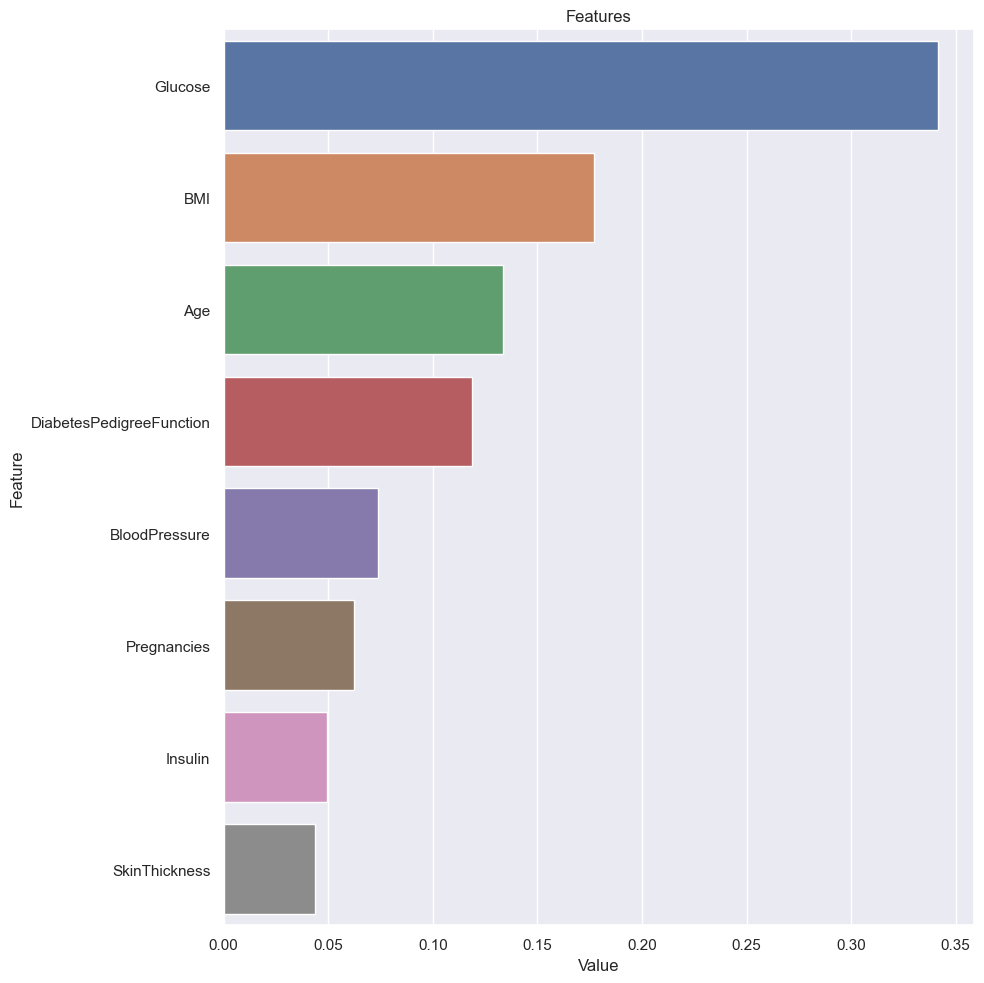

In [23]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

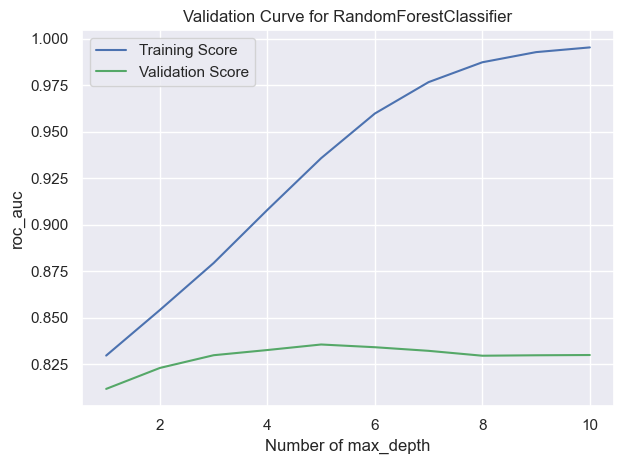

In [24]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 11), scoring="roc_auc")

In [25]:
#Gradient Boosting Machines (GBM)

In [26]:
gbm_model = GradientBoostingClassifier(random_state=17)

#gbm model nesnemiz

In [27]:
#ön tanımlı parametreleri gözlemleyelim

gbm_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [28]:
#n_estimators burada aslında optimizasyon sayısıdır

In [29]:
#modelin hiperparametre optimizasyonundan önceki hatalarına bakalım

cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [30]:
cv_results['test_accuracy'].mean()
# 0.7591715474068416

0.7591715474068416

In [31]:
cv_results['test_f1'].mean()
# 0.634

0.634235802826363

In [32]:
cv_results['test_roc_auc'].mean()
# 0.82548

0.8254867225716283

In [33]:
gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [100, 500, 1000],
              "subsample": [1, 0.5, 0.7]}

#learning_rate ne kadar küçük olursa train seti o kadar uzamaktadır ve küçük olması durumunda daha başarılı tahminler
#elde edilmektedir

#subsample, bütün gözlemleri mi kullanayım yoksa belirli bir kısmını mı göz önünde bulundurayım, bunu ifade eder
#göz önünde bulundurulacak gözlem miktarını 1, %50 ve %70 verdik

In [34]:
gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [35]:
gbm_best_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.5}

In [36]:
#şimdi en iyi parametre ile final modeli kuralım

gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)

In [37]:
cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [38]:
cv_results['test_accuracy'].mean()

0.7800186741363212

In [39]:
cv_results['test_f1'].mean()

0.668605747317776

In [40]:
cv_results['test_roc_auc'].mean()

0.8257784765897973

In [41]:
# XGBoost

In [42]:
xgboost_model = XGBClassifier(random_state=17, use_label_encoder=False)

#modelimizi kurduk

In [43]:
#hiperparametre optimizasyonu öncesi hatalarımıza bakalım

cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [44]:
#hiperparametrelerimize bakalım
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 17,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [45]:
cv_results['test_accuracy'].mean()
# 0.75265

0.7526525761819879

In [46]:
cv_results['test_f1'].mean()
# 0.631

0.6317893713482235

In [47]:
cv_results['test_roc_auc'].mean()
# 0.7987

0.7987134870719776

In [48]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

#colsample_bytree : değişkenlerden alınacak olan gözlem sayısı ile ilgili bir parametre, ön tanımlı değeri 1

In [49]:
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [50]:
xgboost_best_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

In [51]:
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

In [52]:
cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [53]:
cv_results['test_accuracy'].mean()

0.7578643578643579

In [54]:
cv_results['test_f1'].mean()

0.6297649135382188

In [55]:
cv_results['test_roc_auc'].mean()

0.8145597484276731

In [56]:
# LightGBM

In [57]:
lgbm_model = LGBMClassifier(random_state=17)

#model nesnemizi oluşturduk

In [58]:
lgbm_model.get_params()

#parametrelerimize bakalım

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [59]:
#hiperparametre optimizasyonu öncesi hatalarımıza bakalım

cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [60]:
cv_results['test_accuracy'].mean()

0.7474492827434004

In [61]:
cv_results['test_f1'].mean()

0.624110522144179

In [62]:
cv_results['test_roc_auc'].mean()

0.7990293501048218

In [63]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300, 500, 1000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [64]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [65]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}

In [66]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [67]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [68]:
cv_results['test_accuracy'].mean()

0.7643578643578645

In [69]:
cv_results['test_f1'].mean()

0.6372062920577772

In [70]:
cv_results['test_roc_auc'].mean()

0.8147491264849755

In [71]:
# Hiperparametre yeni değerlerle
lgbm_params = {"learning_rate": [0.01, 0.02, 0.05, 0.1],
               "n_estimators": [200, 300, 350, 400],
               "colsample_bytree": [0.9, 0.8, 1]}

In [72]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [73]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [74]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [75]:
cv_results['test_accuracy'].mean()

0.7643833290892115

In [76]:
cv_results['test_f1'].mean()

0.6193071162618689

In [77]:
cv_results['test_roc_auc'].mean()

0.8227931516422082

In [78]:
# Hiperparametre optimizasyonu sadece n_estimators için.
lgbm_model = LGBMClassifier(random_state=17, colsample_bytree=0.9, learning_rate=0.01)

#lgbm'nin en önemli parametresi n_estimators'tur bu yüzden bu şekilde yapılmalı

#diğer 2 parametre değerini sabitledik

In [79]:
lgbm_params = {"n_estimators": [200, 400, 1000, 5000, 8000, 9000, 10000]}

In [80]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [81]:
lgbm_best_grid.best_params_

{'n_estimators': 200}

In [82]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [83]:
cv_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [84]:
cv_results['test_accuracy'].mean()

0.7643833290892115

In [85]:
cv_results['test_f1'].mean()

0.6193071162618689

In [86]:
cv_results['test_roc_auc'].mean()

0.8227931516422082

In [87]:
# CatBoost : Kategorik değişkenler ile otomatik olarak mücadele edebilir

In [88]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)

#catboost'da verbose'u false yapmak öneriliyor

In [89]:
cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

#hiperparametre öncesi hatalarımıza bakalım

In [90]:
cv_results['test_accuracy'].mean()

#0,77

0.7735251676428148

In [91]:
cv_results['test_f1'].mean()

#0.65

0.6502723851348231

In [92]:
cv_results['test_roc_auc'].mean()

#0.83

0.8378923829489867

In [93]:
#basit bir hiperparametre seti girdik

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}

#iterations : ağaç sayısı, boosting sayısı, n_estimators sayısı denebilir
#depth : max_depth

In [94]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [95]:
catboost_best_grid.best_params_

{'depth': 3, 'iterations': 500, 'learning_rate': 0.01}

In [96]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

In [97]:
#final modelimizin hatalarına bakalım 

cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [98]:
cv_results['test_accuracy'].mean()

#0.77

0.7721755368814192

In [99]:
cv_results['test_f1'].mean()

#0.63

0.6322580676028952

In [100]:
cv_results['test_roc_auc'].mean()

#0,84

0.842001397624039

In [101]:
#daha önce kullandığımız yöntemlerin hepsinden daha yüksek bir auc skoru geldi

In [102]:
# Feature Importance

In [103]:
#daha önce kaydettiğimiz bir feature importance fonksiyonu

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

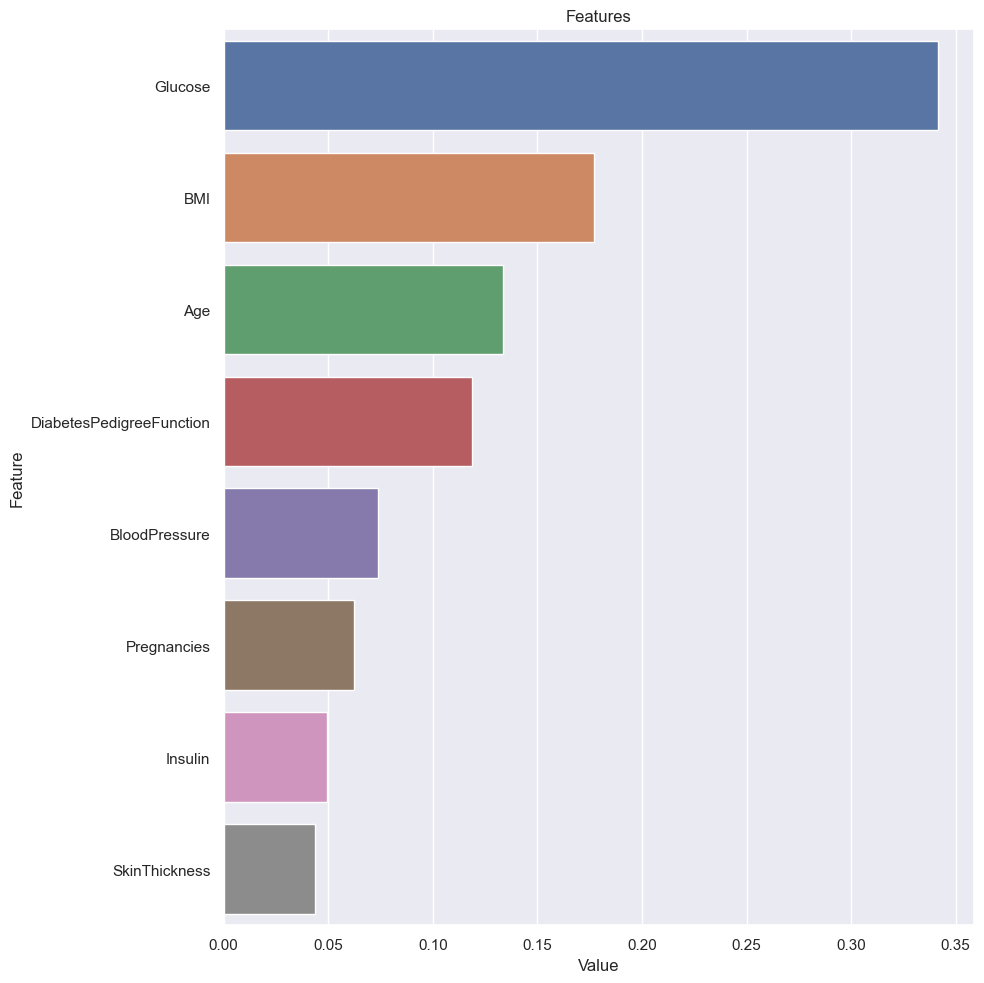

In [104]:
plot_importance(rf_final, X)

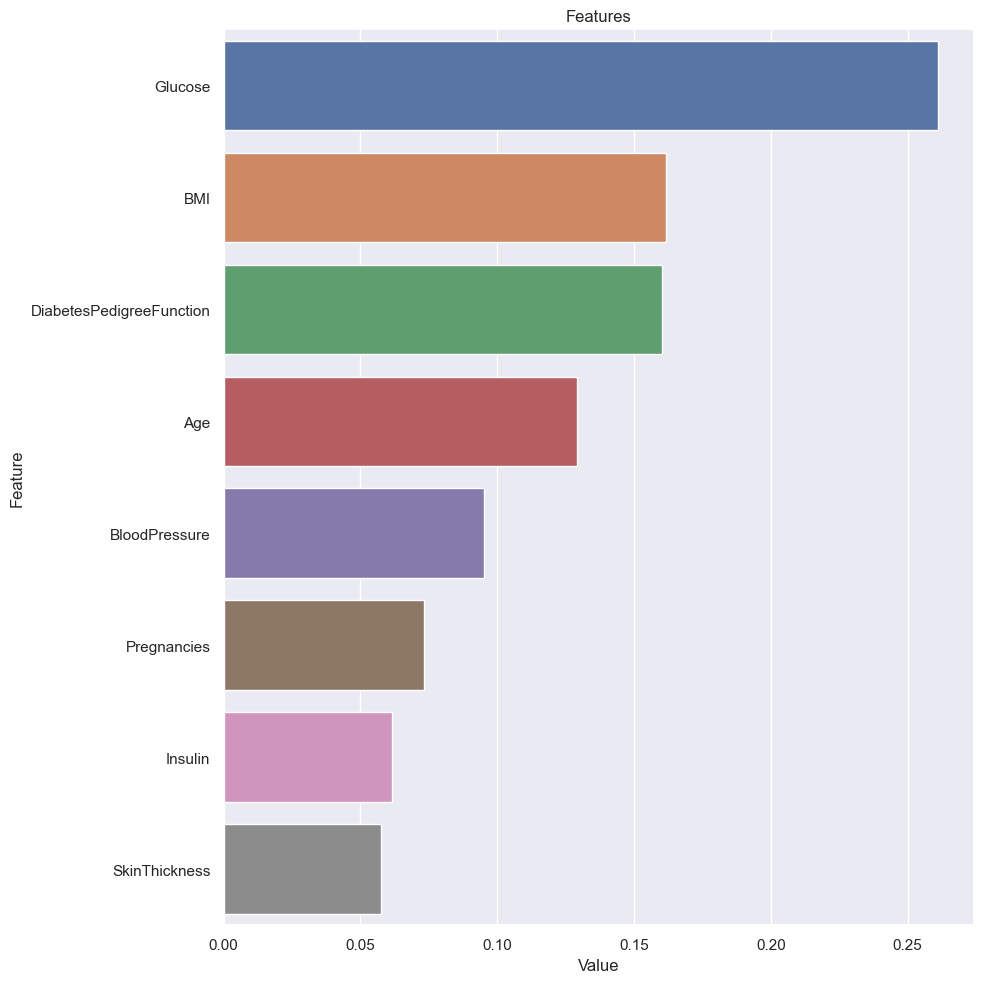

In [105]:
plot_importance(gbm_final, X)

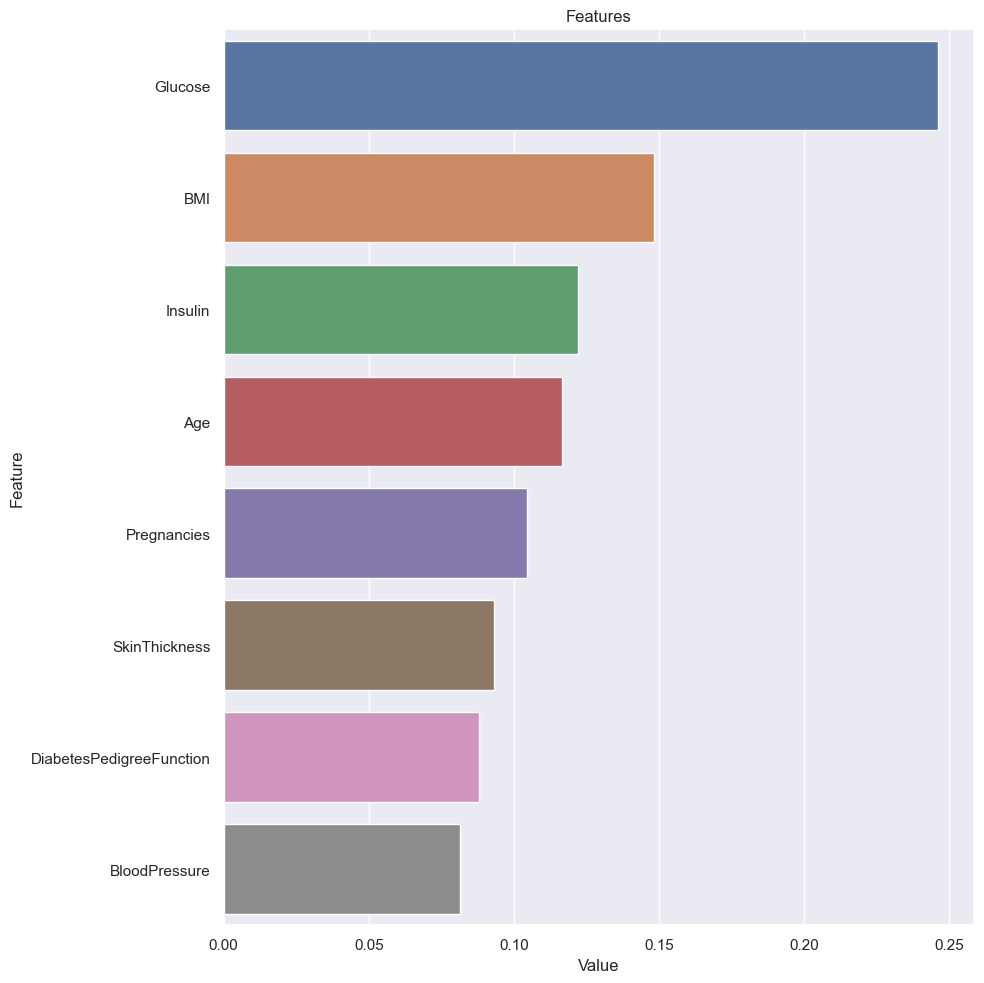

In [106]:
plot_importance(xgboost_final, X)

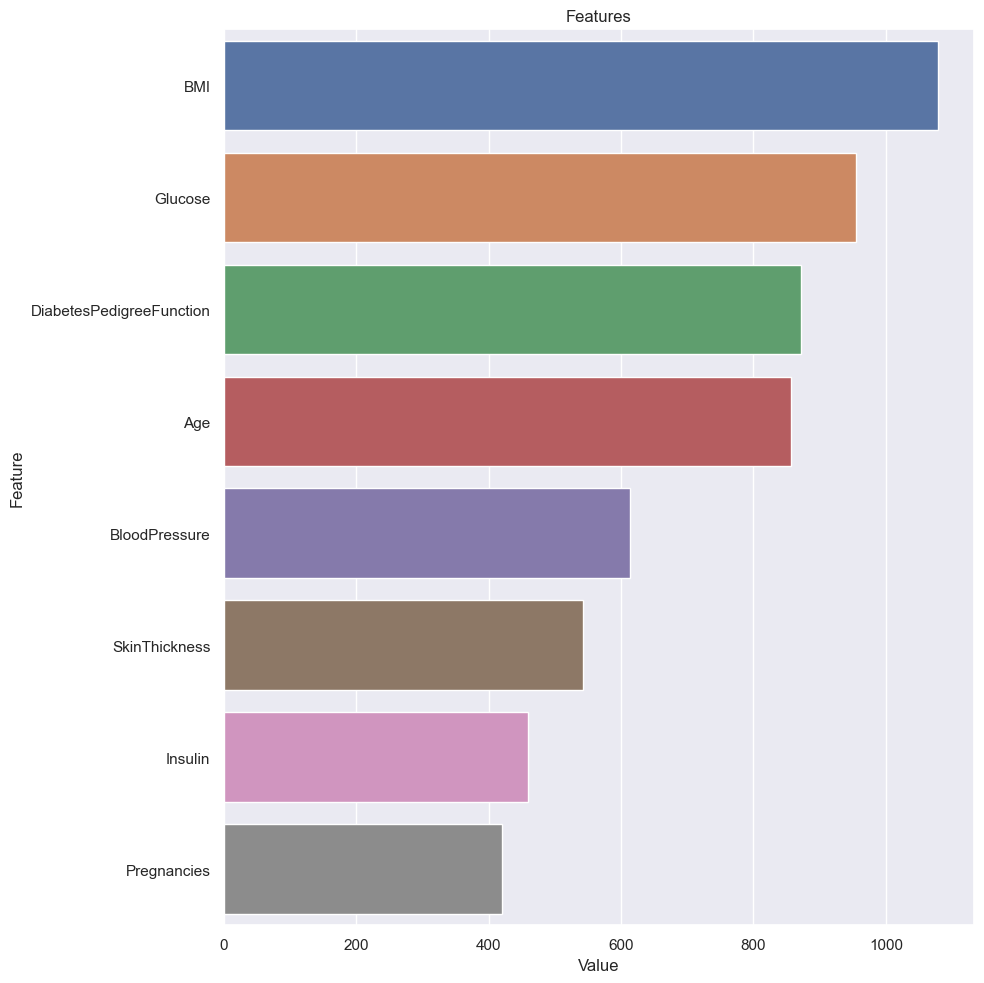

In [107]:
plot_importance(lgbm_final, X)

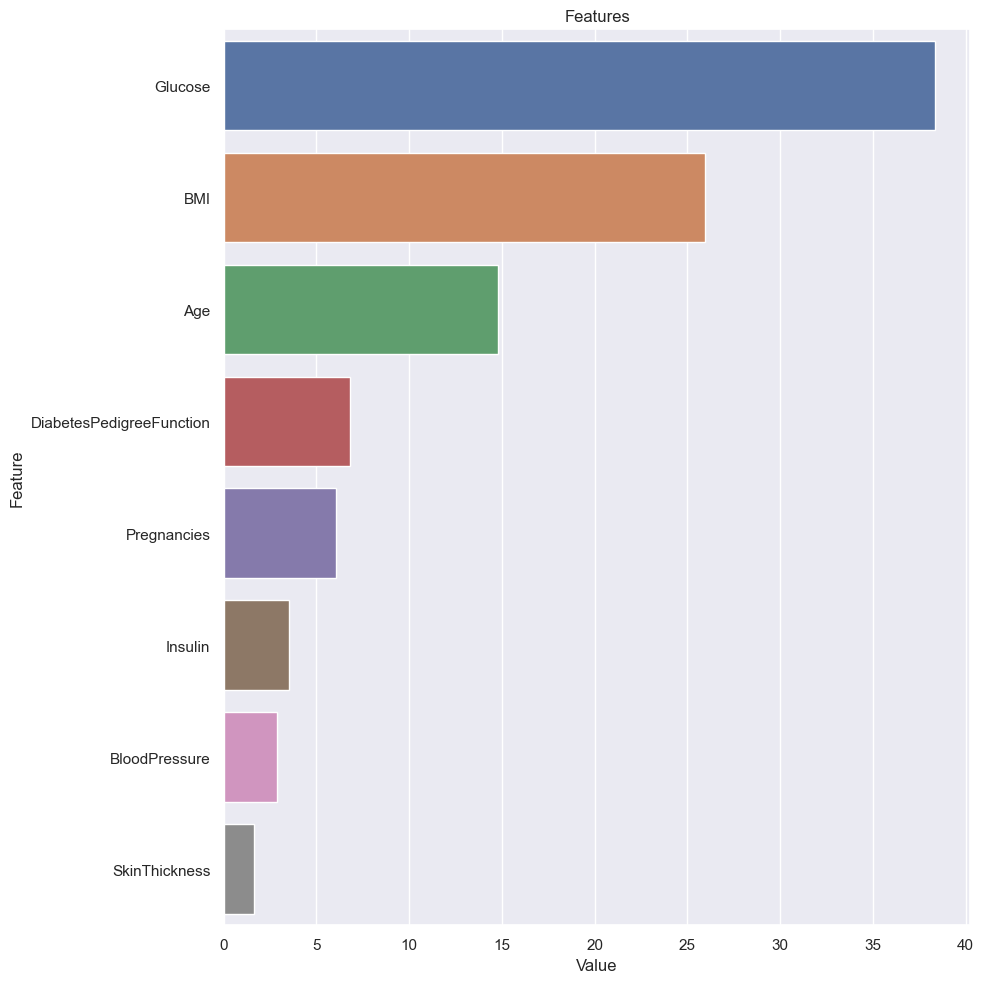

In [108]:
plot_importance(catboost_final, X)

In [109]:
# Hyperparameter Optimization with RandomSearchCV (BONUS)

#RandomSearch Cross Validation Yöntemi

#GridSearchCv Yöntemi verilen bir hiperparametre setinin olası bütün kombinasyonlarını tek tek deniyordu, bu yüzden daha
#uzun sürüyor, olası en iyiyi kapsama ihtimali daha yüksektir

#RandomSearchCv ise verilen bir hiperparametre seti içerisinden rastgele seçimler yapar ve bu rastgele seçimleri arar,
#daha geniş bir hiperparametre adayı arasından rasgele seçim yapar bu seçtikleri üzerinden tek tek deneme yapar
#daha çok tercih edilebilir

In [110]:
#rf modeli için bu işlemi gerçekleştirelim

rf_model = RandomForestClassifier(random_state=17)

In [111]:
rf_random_params = {"max_depth": np.random.randint(5, 50, 10),  #5ten 50ye kadar 10 tane sayı oluştur dedik
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}
                                                                #200den 1500e kadar 10 tane sayı oluştur dedik

In [112]:
rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

In [113]:
rf_random.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([40, 13, 23, 42, 25, 12, 40, 44, 26, 23]),
                                        'max_features': [3, 5, 7, 'auto',
                                                         'sqrt'],
                                        'min_samples_split': array([ 7, 19, 40, 10, 38,  5, 35, 47, 45, 28, 14, 21, 49, 36, 41, 12, 13,
        8,  5, 44]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [114]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 28,
 'max_features': 'sqrt',
 'max_depth': 42}

In [115]:
#best parametrelere göre bir model kuralım

rf_random_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

In [116]:
cv_results = cross_validate(rf_random_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

In [117]:
cv_results['test_accuracy'].mean()
#0,76

0.7682879212290977

In [118]:
cv_results['test_f1'].mean()
#0,61

0.6293202548677237

In [119]:
cv_results['test_roc_auc'].mean()
#0,83

0.8361495457721873

In [120]:
#öncekilerden daha iyi görünüyor

In [121]:
# Analyzing Model Complexity with Learning Curves (BONUS)

In [122]:
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)
    
    
#daha geniş ve daha farklı parametre setleri vererek auc değerine göre öğrenme eğrilerini oluşturarak model karmaşıklığını
#diğer ifadeyle overfit'e düşüp düşmeme durumumuzu değerlendirmek adına bir bakış sağlayalım

In [123]:
rf_val_params = [["max_depth", [5, 8, 15, 20, 30, None]],
                 ["max_features", [3, 5, 7, "auto"]],
                 ["min_samples_split", [2, 5, 8, 15, 20]],
                 ["n_estimators", [10, 50, 100, 200, 500]]]

#bir liste içerisinde parameterleri ve denenecek olan değerleri girdik

In [124]:
rf_model = RandomForestClassifier(random_state=17)

#model nesnemizi oluşturduk

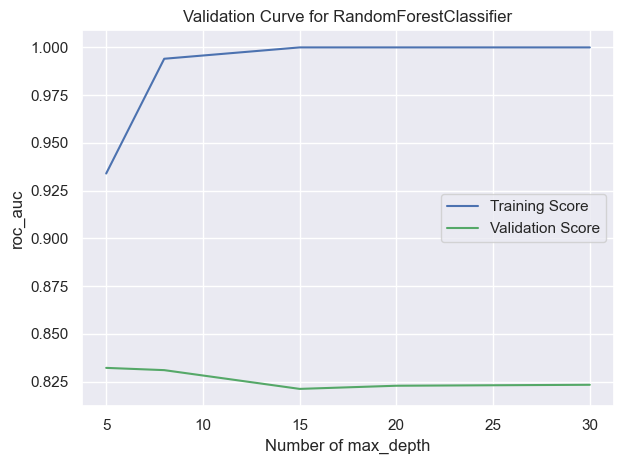

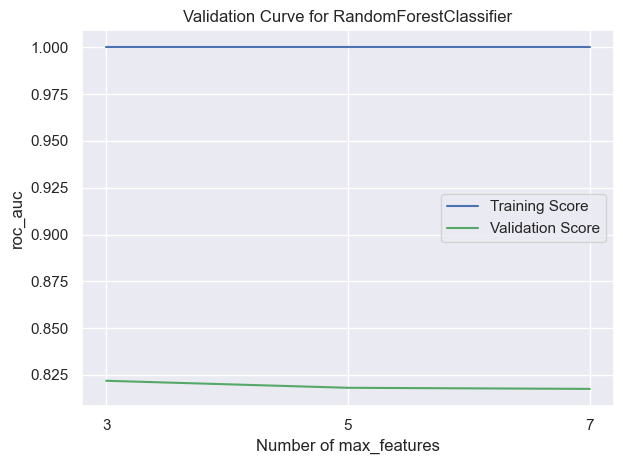

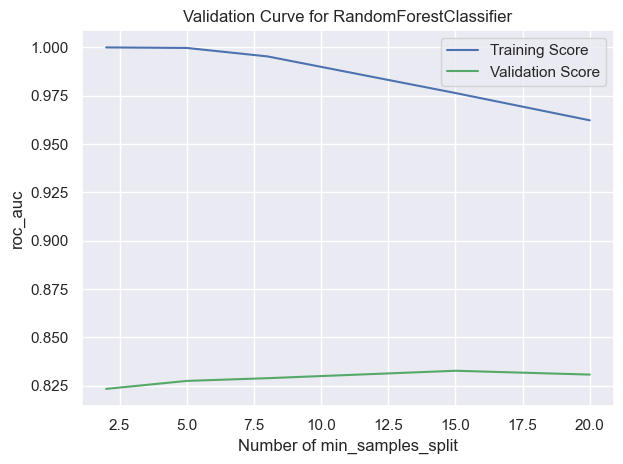

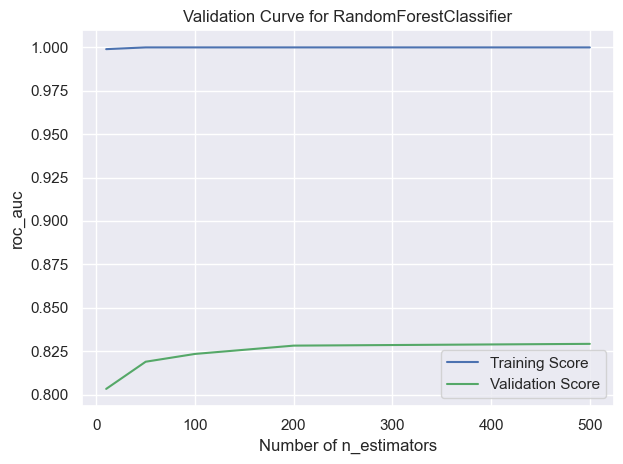

In [125]:
for i in range(len(rf_val_params)):
    val_curve_params(rf_model, X, y, rf_val_params[i][0], rf_val_params[i][1])
    
#val_curve_params isimli fonksiyonumuzu ilgili parametre değerleri ve ilgili isimleri alacak şekilde biçimlendirerek 
#kullanıyoruz

In [126]:
rf_val_params[0][1]

[5, 8, 15, 20, 30, None]